## DETECTION AND ATTRIBUTION

This notebook is an attempt to create a model to do a "Detection and Attribution" study out of our findings. 

It builds on the correlation of climatic indices (SAM, ENSO, IOD, Polar vortex) to the mooring data, outlining a possible approach using a multiple linear regression model. This approach assumes a linear relationship between the climatic indices and the upwelling phenomenon - which might not be true and needs a bit of research on still.

### STEPS THAT SHOULD BE DONE BEFORE GETTING HERE: 

STEP 1: Data Preparation
1. Collect historical data for the South Australian upwelling (mooring data from IMOS) and the climatic indices (SAM, ENSO, IOD, Polar vortex, etc) for the same time period. 
2. Preprocess the data to handle missing values, outliers, and inconsistencies.
- relevant notebooks: 


Step 2: Correlation Analysis
1. Calculate Pearson correlation coefficients between the upwelling data and each climatic index. This initial analysis will give you a sense of the relationships.
- relevant notebooks: 

### STEPS STILL TO DO: 
Step 1: Multiple Linear Regression Model
1. Organize your data into a dataset with columns for the upwelling and the climatic indices.
2. Divide the dataset into training and testing sets for model validation.

Step 2: Model Building and training.
1. Build the multiple linear regression model 
2. Train the model using the training dataset. The model will learn the relationships between the upwelling and the climatic indices.

Step 3: Model Evaluation
1. Evaluate the model's performance using the testing dataset. Metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared can assess how well the model fits the data.

Step 4: Interpretation
1. Interpret the model coefficients. A positive coefficient indicates a positive correlation between the climatic index and the upwelling, while a negative coefficient indicates a negative correlation.

Step 5: Scenario Analysis and Visualization
1. Simulate different scenarios by altering the values of the climatic indices in the model.
2. Plot the simulated upwelling values against the original observed values for visual comparison.

Step 8: Sensitivity Analysis
1. Perform sensitivity analysis by introducing variations in the climatic indices and observing their effects on the simulated upwelling.

Step 9: Discussion and Implications
1. Discuss the results of your model in the context of the South Australian upwelling phenomenon and the role of the climatic indices in its suppression.
2. Highlight any interesting findings, interactions between indices, and potential implications for the marine ecosystem.

Step 10: other models. 
1. You might need to explore more advanced modeling techniques, such as nonlinear regression, machine learning algorithms, or time series analysis, depending on the complexity of the relationships and the data.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sc = StandardScaler()

### 1. Data Loading

In [2]:
# Upwelling data
dataframes = dict()
dataframes["Upwelling"] = pd.read_csv("../Datasets/NRSKAI_TEMP_101-111m.csv")
dataframes["Upwelling"]["date"] = pd.to_datetime(dataframes["Upwelling"]["TIME"])
dataframes["Upwelling"] = dataframes["Upwelling"][["TEMP", "DEPTH", "date"]].rename(columns={"TEMP": "Mooring Temp", "DEPTH": "Mooring Depth"})

# Indexes
files = {
    "SAM": "../Datasets/SAM_index.csv",
    "ENSO": "../Datasets/SOI_index.csv",
    "IOD": "../Datasets/iod_index.csv",
    "Polar_vortex": "../Datasets/Vortex_datasets.csv"
}

for k, v in files.items():
    dataframes[k] = pd.read_csv(v)

# Format dates to extract year
for df in "Upwelling SAM ENSO IOD".split():
    dataframes[df]["date"] = pd.to_datetime(dataframes[df]["date"], dayfirst=True)
    dataframes[df]["Year"] = dataframes[df]["date"].dt.year
    dataframes[df]["Month"] = dataframes[df]["date"].dt.to_period("M")
    dataframes[df] = dataframes[df].groupby("Month").mean(numeric_only=True)
    
dataframes["Polar_vortex"] = dataframes["Polar_vortex"].dropna().copy()
dataframes["Polar_vortex"]["Year"] = dataframes["Polar_vortex"]["Year"].astype(int)
dataframes["Polar_vortex"] = dataframes["Polar_vortex"].set_index("Year")

In [3]:
data = pd.DataFrame(index = dataframes["Upwelling"].index)
for k, v in dataframes.items():
    if k != "Polar_vortex":
        data = data.merge(v.drop("Year", axis=1), left_index=True, right_index=True)

In [4]:
rename_dict = {'Mooring Temp': "Mooring Temp",
               'Mooring Depth': "Mooring Depth",
               'sam_index': "SAM",
               'soi_index': "ENSO",
               'iod_index': "IOD",
               'S-Tmode_Lim_et_al_2018': "Polar vortex 1",
               'Sep-Nov[U]_60S10hPa_JRA55': "Polar vortex 2"}

data = data.rename(columns=rename_dict)
data = data.dropna(subset="Mooring Temp")

In [5]:
# Separate features (climatic indices) and target (upwelling) variables
X = data[['SAM', 'ENSO', 'IOD',]] # 'Polar vortex 1', 'Polar vortex 2']]
y = data['Mooring Temp']

### 2. Model Building and Training

Mean Squared Error: 2.9778976729829507
R-squared: 0.01202105605618764


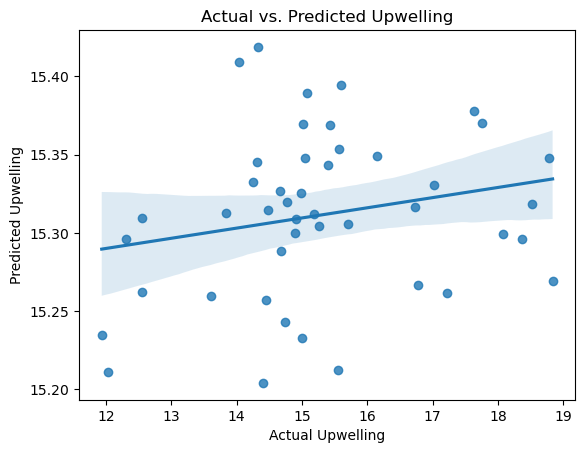

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot the predicted vs. actual upwelling values
# plt.scatter(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Actual Upwelling")
plt.ylabel("Predicted Upwelling")
plt.title("Actual vs. Predicted Upwelling")
plt.show()


### Random Forest Regressor

Mean Squared Error: 2.9942673479840565
R-squared: 0.006590078905083674


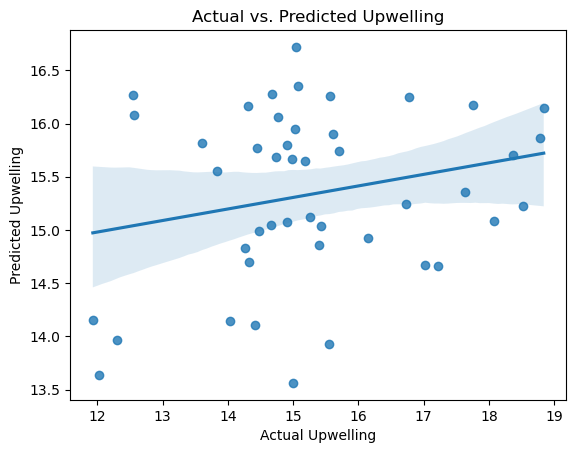

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# # Standard scaler
# X_train, X_test, y_train, y_test = (sc.fit_transform(X_train),
#                                    sc.fit_transform(X_test),
#                                    sc.fit_transform(np.asarray(y_train).reshape(-1, 1)),
#                                    sc.fit_transform(np.asarray(y_test).reshape(-1, 1)))


# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot the predicted vs. actual upwelling values
# plt.scatter(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Actual Upwelling")
plt.ylabel("Predicted Upwelling")
plt.title("Actual vs. Predicted Upwelling")
plt.show()